### NOTE

The notebook for this project isn’t designed to run linearly from top to bottom. Due to multiple runtime disconnections during training, I had to reload saved variables (like model weights and training history) and selectively re-execute specific cells to resume progress. As a result, the execution flow became more modular and state-dependent, rather than strictly sequential.

This structure reflects the practical realities of long-running experiments in cloud environments, where resilience and checkpointing are essential. While it may not follow a clean top-down script, it’s built to recover gracefully and continue training without loss of progress.

For reproducibility, key checkpoints (model, history, tokenizer) are saved externally and can be reloaded independently of notebook order.

In [1]:
# Core libraries
import os
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

# TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, concatenate, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, load_model

 Data source: https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset

In [2]:
# Mount Google Drive in Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive

MyDrive


In [ ]:
# Install Kaggle API
# !pip install kaggle

### Don't run! This is only run once!

In [ ]:
# Upload your Kaggle API key
# Go to Kaggle → Account → settings → API → Create New Token
# This downloads a file called kaggle.json
# Upload it in Colab
from google.colab import files
files.upload()   # When the dialog opens, select kaggle.json from your computer

### Don't run! This is only run once!

In [ ]:
# Move kaggle.json to the right place
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

### Don't run! This is only run once!

In [ ]:
# Make a folder for dataset
!mkdir -p /content/drive/MyDrive/flickr30k

### Don't run! This is only run once!

In [ ]:
# Download into Drive
!kaggle datasets download hsankesara/flickr-image-dataset -p /content/drive/MyDrive/flickr30k

### Don't run! This is only run once!

In [ ]:
# Unzip into the folder
!unzip /content/drive/MyDrive/flickr-image-dataset.zip -d /content/drive/MyDrive

### Runtime > Run cell and below

In [ ]:
# Mount Google Drive in Colab
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Show counts of files in each subdirectory
!find /content/drive/MyDrive/flickr30k_images/ -type d -exec sh -c 'echo -n "{}: "; find "{}" -maxdepth 1 -type f | wc -l' \;

In [ ]:
!find /content -type f -name "*results.csv*"

In [ ]:
# How many images do we have?
import os

image_dir = "/content/drive/MyDrive/flickr30k_images/flickr30k_images"
num_images = sum(len(files) for _, _, files in os.walk(image_dir))
print("Total images:", num_images)

In [ ]:
len(os.listdir(image_dir))


In [ ]:
# How many captions do we have?
csv_path = "/content/drive/MyDrive/flickr30k_images/results.csv"

with open(csv_path, "r", encoding="utf-8") as f:
    num_lines = sum(1 for _ in f)

print("Total lines in CSV:", num_lines)

In [ ]:
# How many captions does each images have?
(num_lines-1)/num_images

### Display some of the images

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import pathlib

imgdir_path = pathlib.Path('/content/drive/MyDrive/flickr30k_images/flickr30k_images/')
img_list = sorted([str(path) for path in imgdir_path.glob('*.jpg')])

fig = plt.figure(figsize=(16, 8))
for i, f in enumerate(img_list[:10]):
  img_raw = tf.io.read_file(f)
  img = tf.image.decode_jpeg(img_raw).numpy()
  ax = fig.add_subplot(2, 5, i+1)
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(img)
  ax.set_title(f"{os.path.basename(f)}\n{img.shape}", size=15)
plt.tight_layout()
plt.show();

### Display captions in a dataframe

In [ ]:
import pandas as pd

csv_path = "/content/drive/MyDrive/flickr30k_images/results.csv"
df = pd.read_csv(csv_path, delimiter='|')
df.head(12)

In [ ]:
df.columns

In [ ]:
df.columns = df.columns.str.strip()

In [ ]:
df.describe()

In [ ]:
# Save df
with open('/content/drive/MyDrive/flickr30k_images/df.pkl', 'wb') as f:
    pickle.dump(df, f)

### Define function to preprocess text and delimit each caption

In [ ]:
import string
import nltk

table = str.maketrans('', '', string.punctuation)  # just delete punctuations

def text_preprocess(text):

  text = text.lower().split()
  text = [word for word in text if word.isalpha()]
  text = [w.translate(table) for w in text]
  text = [word for word in text if len(word)>1]
  text = "startseq "+' '.join(text)+ " endseq"

  return text

### Associates each image name with a list of preprocessed comments.

In [ ]:
mapping =  {}
for i,c in zip(df.image_name, df.comment):
  if i in mapping.keys():  # if i in mapping:
    if(type(c)==str):
      mapping[i].append(text_preprocess(c))
  else:
    mapping[i]=[text_preprocess(c)]

# Save mapping
with open('/content/drive/MyDrive/flickr30k_images/mapping.pkl', 'wb') as f:
    pickle.dump(mapping, f)

In [ ]:
mapping['1006452823.jpg']

### Estimation of caption length

In [ ]:
all_captions=[]
for key in mapping:
  for caption in mapping[key]:
    all_captions.append(caption)

# Save all_captions
with open('/content/drive/MyDrive/flickr30k_images/all_captions.pkl', 'wb') as f:
    pickle.dump(all_captions, f)


# Max length of the caption available
max_length_cap=max(len(caption.split())for caption in all_captions)
max_length_cap

### Extract vocabulary with tokenizer

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

# Save tokenizer
with open('/content/drive/MyDrive/flickr30k_images/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

vocab_dict = tokenizer.word_index
vocab_size = len(vocab_dict)+1         # total number of unique word, reserve index 0 for padding
vocab_size

In [ ]:
# Confirm startseq, endseq exists in tokens
print(tokenizer.word_index.get('startseq'))
print(tokenizer.word_index.get('endseq'))

In [ ]:
# Save metadata
meta = {
    'vocab_dict': tokenizer.word_index,
    'vocab_size': len(tokenizer.word_index) + 1,
    'max_length_cap': max(len(c.split()) for c in all_captions)
}
with open('/content/drive/MyDrive/flickr30k_images/meta.pkl', 'wb') as f:
    pickle.dump(meta, f)

### Pretrained model for image feature extraction
About VGG: https://keras.io/api/applications/vgg/  Very Deep Convolutional Networks for Large-Scale Image Recognition.

VGG16 has been trained on a large subset of the ImageNet dataset, which contains over 14 million images, although the specific number of training images is about 1.2 million. The VGG16 model was designed to classify images into 1,000 object categories and achieved a high classification accuracy in the ImageNet Large Scale Visual Recognition Challenge (ILSVRC)-2014.

### Setup VGG

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model

vgg_model = VGG16(weights = 'imagenet')
# Trimming off the classification head and keeping the 4096-d feature vector from fc2
vgg_model = Model(inputs = vgg_model.inputs, outputs = vgg_model.layers[-2].output)
vgg_model.summary()

### Define function to extract features from images

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tqdm import tqdm  # for progress bar

def extract_feature(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))  # the input size expected by VGG16
    img_array = image.img_to_array(img)                     #convert the image pixel to a numpy array
    img_array = np.expand_dims(img_array, axis=0)           # to match batch input shape
    img_array = preprocess_input(img_array)                 # VGG16’s training requirement

    feature = model.predict(img_array, verbose=0)           # extract the feature vector from the fc2 layer
    return feature.flatten()

### Usage: call function

In [ ]:
# features_dict = extract_features(img_list, vgg_model)
# print(f"Extracted features for {len(features_dict)} images.")

### Checkpointing Feature Extraction
- Step 1: Save features incrementally

In [ ]:
from tqdm import tqdm
import os
import pickle
from pathlib import Path

imgdir_path = Path('/content/drive/MyDrive/flickr30k_images/flickr30k_images/')
save_path = imgdir_path.parent / 'features'
os.makedirs(save_path, exist_ok=True)

img_paths = list(imgdir_path.glob("*.jpg"))

for img_path in tqdm(img_paths, desc="Extracting features"):
    img_name = img_path.name
    feature_file = save_path / img_name.replace('.jpg', '.pkl')

    if feature_file.exists():
        continue

    feature = extract_feature(str(img_path), vgg_model)
    img_id = img_name.split('.')[0]
    with open(feature_file, 'wb') as f:
        pickle.dump({img_id: feature}, f)

- Step 2: Resume from saved files
- After disconnecting runtime go back to Step 1 above

### Reconstructs features_dict in memory

In [ ]:
from tqdm import tqdm
import pickle

features_dict = {}

# Wrap the iterable with tqdm to show progress
for file in tqdm(save_path.glob("*.pkl"), desc="Loading features"):
    with open(file, 'rb') as f:
        features = pickle.load(f)
        features_dict.update(features)

print(f"\nLoaded features for {len(features_dict)} images.")


### Pickle the hard earned features dictionary

In [ ]:
import pickle

with open('/content/drive/MyDrive/flickr30k_images/features.pk', 'wb') as f:
    pickle.dump(features_dict, f)

In [ ]:
!find /content -type f -name "features.pk"

### Look at the feature vectors like a dataframe

In [ ]:
import pandas as pd
import numpy as np

# Assuming features_dict maps image_id → np.array of shape (4096,)
df_features = pd.DataFrame.from_dict(features_dict, orient='index')

# Optional: add column names
df_features.columns = [f'feat_{i}' for i in range(df_features.shape[1])]

# Preview
df_features.head()

👇👇👇👇👇👇👇👇👇👇👇👇👇👇👇👇👇

### After yet another disconnection, to use pickled features mount the drive again
Retrive image features, df, mapping...

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Utility: Reload environment after runtime reset
import pickle

# Reload mapping
with open('/content/drive/MyDrive/flickr30k_images/mapping.pkl', 'rb') as f:
    mapping = pickle.load(f)
print("Mapping loaded:", len(mapping))

# Reload all_captions
with open('/content/drive/MyDrive/flickr30k_images/all_captions.pkl', 'rb') as f:
    all_captions = pickle.load(f)
print("All captions loaded:", len(all_captions))

# Reload tokenizer
with open('/content/drive/MyDrive/flickr30k_images/tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)
print("Tokenizer vocabulary size:", len(tokenizer.word_index))

# Reload metadata
with open('/content/drive/MyDrive/flickr30k_images/meta.pkl', 'rb') as f:
    meta = pickle.load(f)
vocab_dict = meta['vocab_dict']
vocab_size = meta['vocab_size']
max_length_cap = meta['max_length_cap']
print("Vocab size:", vocab_size)
print("Max caption length:", max_length_cap)

# Reload image features
with open('/content/drive/MyDrive/flickr30k_images/features.pk', 'rb') as f:
    Img_features = pickle.load(f)
print(type(Img_features))  # should be dict
print("Image features loaded:", len(Img_features))

Mapping loaded: 31783
All captions loaded: 158914
Tokenizer vocabulary size: 17892
Vocab size: 17893
Max caption length: 74
<class 'dict'>
Image features loaded: 31783


### By splitting captions on image_ids, ensure that:

- Each image (and all its captions) is entirely in either train or test.

- Prevents data leakage across captions, the model never sees the same image in both phases.

In [4]:
#Train test split
image_ids = list(mapping.keys())
split = int(len(image_ids)*0.9)

train_id = image_ids[:split]
print(len(train_id))

test_id = image_ids[split:]
print(len(test_id))

28604
3179


In [5]:
import random
for img_id in random.sample(train_id, 5):
    img_id=img_id.split('.')[0]
    print(img_id, np.mean(Img_features[img_id]), np.std(Img_features[img_id]))


1034276567 0.5817712 1.326752
5690228281 0.51859903 0.9498792
2493699743 0.48645258 1.1043835
6153400574 0.5156457 0.9937519
2344699642 0.67819726 1.1201388


### Construct a multimodel with functional API:


### Combining visual features from images and textual sequences from comments

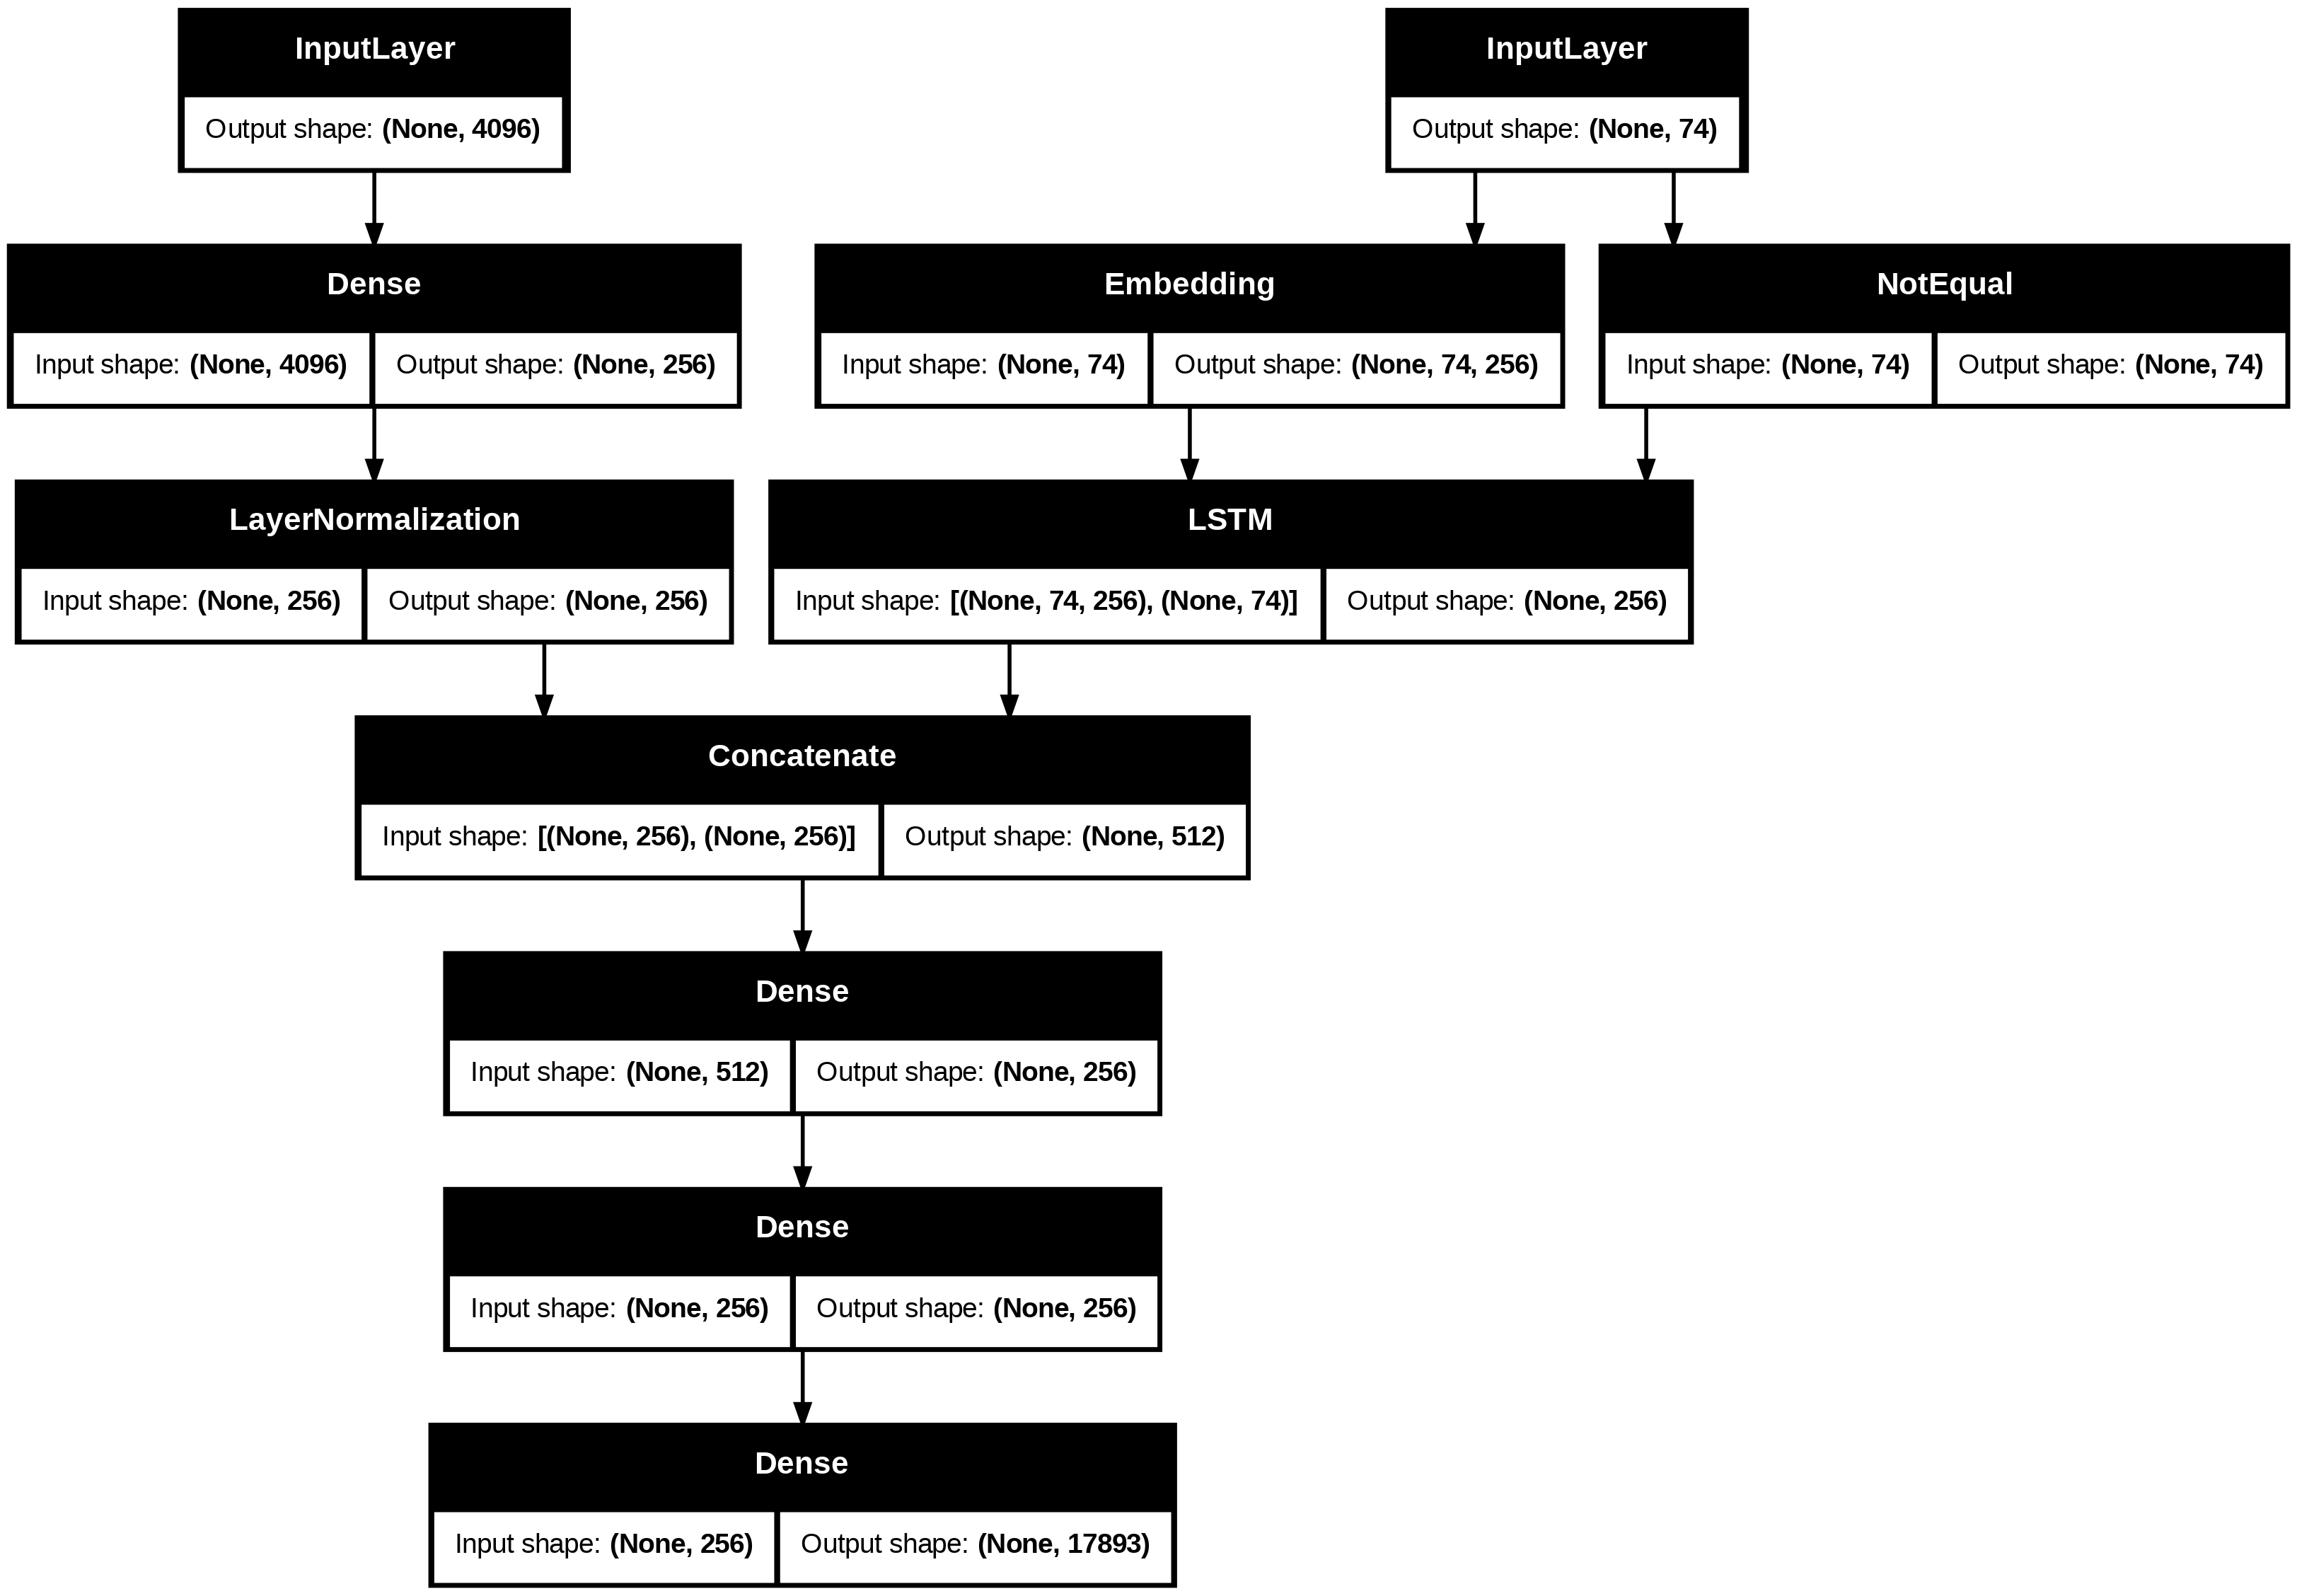

In [6]:
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, concatenate, LayerNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model

# Image Feature layers
inputs1 = Input(shape=(4096,), name='image_input')
Features1 = Dense(256, activation='relu', name='image_dense')(inputs1)
Features2 = LayerNormalization(name='image_norm')(Features1)

# Text Feature layers
inputs2 = Input(shape=(max_length_cap,), name='text_input')
seq1 = Embedding(vocab_size, 256, mask_zero=True, name='text_embedding')(inputs2)
seq2 = LSTM(256, name='text_lstm')(seq1)

# Fusion
fusion = concatenate([Features2, seq2], name='fusion_concat')
decoder1 = Dense(256, activation='relu', name='decoder_dense1')(fusion)
decoder2 = Dense(256, activation='relu', name='decoder_dense2')(decoder1)

# Output
outputs = Dense(vocab_size, activation='softmax', name='output_layer')(decoder2)

# Functional API
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Plot the model
plot_model(model, show_shapes=True)

NotEqual is an internal layer created by mask_zero=True in the Embedding layer. It checks: `input != 0`

This mask is passed to the LSTM so it can ignore padding tokens during training.

In [7]:
# One quick dummy forward pass
import numpy as np

dummy_img = np.random.rand(1, 4096)
dummy_seq = np.random.randint(1, vocab_size, size=(1, max_length_cap))

# softmax score, 1D array of probabilities over the vocabulary (vocab_size = 17892)
# the model's confidence that a particular word is the next in the caption
model.predict([dummy_img, dummy_seq])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[5.3081731e-05, 5.7947516e-05, 5.3758045e-05, ..., 5.7294586e-05,
        5.7800382e-05, 5.8883772e-05]], dtype=float32)

In [8]:
image_id = train_id[0].split('.')[0]
print("Image vector mean/std:", np.mean(Img_features[image_id]), np.std(Img_features[image_id]))
print("Captions:", mapping[train_id[0]])


Image vector mean/std: 0.5856419 1.1218929
Captions: ['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq', 'startseq two young white males are outside near many bushes endseq', 'startseq two men in green shirts are standing in yard endseq', 'startseq man in blue shirt standing in garden endseq', 'startseq two friends enjoy time spent together endseq']


### Define data generator to prepare training data for a multi-input model
**(image features, partial caption) → next word**

In [5]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import random

def data_generator(data_keys, features, mapping, tokenizer, max_length, vocab_size, batch_size):
    """
    Generator that yields batches of training data for image captioning.
    Each sample consists of:
    - X1: image feature vector (from CNN)
    - X2: input sequence of word indices (padded)
    - y: target word index (integer, not one-hot)

    This version is optimized for use with sparse_categorical_crossentropy.
    """
    X1, X2, y = [], [], []
    n = 0

    while True:
        # Shuffle image keys to randomize batch order
        random.shuffle(data_keys)

        for key in data_keys:
            n += 1    # Image level batching
            captions = mapping[key]

            # Process each caption associated with the current image
            for caption in captions:
                # Convert caption text to a sequence of token IDs
                seq = tokenizer.texts_to_sequences([caption])[0]

                # Generate multiple input-output pairs from the sequence
                for i in range(1, len(seq)):
                    # Input sequence: all tokens before position i
                    in_seq = seq[:i]
                    # Output token: the token at position i
                    out_seq = seq[i]

                    # Skip if target word is padding (index 0)
                    if out_seq == 0:
                        continue

                    # Pad input sequence to fixed length
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]

                    # Get image ID (strip file extension)
                    image_id = key.split('.')[0]

                    # Sanity checks
                    assert image_id in features, f"Missing image_id: {image_id}"
                    assert features[image_id].shape == (4096,), f"Bad shape: {features[image_id].shape}"

                    # Append sample to batch buffers
                    X1.append(features[image_id])  # image features
                    X2.append(in_seq)              # input sequence
                    y.append(out_seq)              # target word index (integer)

            # Yield batch when full
            if n == batch_size:
                yield (np.array(X1), np.array(X2)), np.array(y)
                X1, X2, y = [], [], []
                n = 0

### 🛠️ Debugging Report: The `n` That Made the Model Learn

For many tries, the model struggled to reach meaningful accuracy. The architecture was sound, the optimizer tuned, and the loss function appropriate. The issue lay deeper, in the **data generator**.

The key insight came from examining the batching logic: the counter `n`, which tracks how many samples have been added to the current batch. Originally, `n += 1` was placed inside the innermost loop, incrementing once per caption token pair. This caused batches to fill too quickly, often with **incomplete or imbalanced samples**, leading to noisy updates and slow convergence.

The fix was counterintuitive: moving `n += 1` to the **outer loop**, where it increments once per image key. This change ensured that batches were built around complete image-caption contexts, yielding **more coherent and semantically aligned training samples**.

The result? A dramatic acceleration in learning. The model reached 30% accuracy by **epoch 3**, a milestone that previously took 150 epochs. The training loop was no longer just feeding data, it was feeding **meaningful structure**.


---

### 📊 Effect of `n += 1` Placement in `data_generator`

| **Placement of `n += 1`**       | **Meaning**                                                                 | **Batching Behavior**                                  | **Training Result**                            |
|----------------------------------|------------------------------------------------------------------------------|---------------------------------------------------------|-------------------------------------------------|
| ✅ **Outer loop** (`for key in data_keys`) | Increment once per image key (i.e., per image)                             | Batches built around full image-caption context         | Good convergence — 30% accuracy by epoch 3      |
| ❌ **Inner loop** (`for i in range(1, len(seq))`) | Increment once per token pair (i.e., per word prediction)                  | Batches fill too fast with fragmented samples           | No convergence — 30% accuracy after ~150 epochs |

---

### 💡 Insight

Placing `n += 1` in the outer loop ensures that batches are semantically coherent, each sample reflects a meaningful image-caption pair. The inner loop placement fragments the data, leading to noisy gradients and inefficient learning.

In [10]:
# Create a generator instance
test_generator = data_generator(
    data_keys = train_id,           # or test_id if you want to inspect test samples
    features = Img_features,
    mapping = mapping,
    tokenizer = tokenizer,
    max_length = max_length_cap,
    vocab_size = vocab_size,
    batch_size = 64                # match your training batch size
)

# Fetch one batch from the generator
(X1_batch, X2_batch), y_batch = next(test_generator)

# Print shapes to verify structure
print("Image vector shape:  X1_batch", X1_batch.shape)       # Expected: (64, 4096)
print("Caption input shape: X2_batch", X2_batch.shape)        # Expected: (64, max_length)
print("Target shape:        y_batch ", y_batch.shape)          # Expected: (64, vocab_size)

# Fetch one batch from the generator
(X1_batch, X2_batch), y_batch = next(test_generator)

# Inspect one sample
print("\nSample image vector (mean/std):", np.mean(X1_batch[0]), np.std(X1_batch[0]))
print("Sample image vector [:20]\n", X1_batch[0][:20])
print("Sample input sequence:", X2_batch[0])
print("Sample target word:", np.argmax(y_batch[0]))


Image vector shape:  X1_batch (3819, 4096)
Caption input shape: X2_batch (3819, 74)
Target shape:        y_batch  (3819,)

Sample image vector (mean/std): 0.57175183 0.96816754
Sample image vector [:20]
 [1.1891752  0.         0.         0.         1.153603   0.44730073
 0.         2.3909984  1.2596074  2.2940423  0.         0.3488623
 0.         0.         0.         0.         0.         0.
 2.210817   0.        ]
Sample input sequence: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Sample target word: 0


In [11]:
for i in range(5):
    print(f"\nSample {i}")
    print("Input sequence:", X2_batch[i])
    print("Target word index:", np.argmax(y_batch[i]))


Sample 0
Input sequence: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Target word index: 0

Sample 1
Input sequence: [ 1 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]
Target word index: 0

Sample 2
Input sequence: [  1  17 687   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
Target word index: 0

Sample 3
Input sequence: [   1   17  687 1252    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0 

### Feature Scale Inspection

In [12]:
from tensorflow.keras.models import Model
import numpy as np

# Create inspection model
inspect_model = Model(inputs=model.inputs, outputs=[
    model.get_layer('image_norm').output,   # Normalized image features
    model.get_layer('text_lstm').output     # Encoded text features
])

In [13]:
(X_img, X_seq), _ = next(test_generator)
img_features, text_features = inspect_model.predict([X_img, X_seq])

def describe(name, tensor):
    print(f"{name} — shape: {tensor.shape}")
    print(f"  Mean: {np.mean(tensor):.4f}")
    print(f"  Std:  {np.std(tensor):.4f}")
    print(f"  Min:  {np.min(tensor):.4f}")
    print(f"  Max:  {np.max(tensor):.4f}")
    print()

describe("Normalized Image Features", img_features)
describe("Encoded Text Features", text_features)


113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Normalized Image Features — shape: (3616, 256)
  Mean: -0.0000
  Std:  0.9995
  Min:  -0.7777
  Max:  5.5884

Encoded Text Features — shape: (3616, 256)
  Mean: 0.0000
  Std:  0.0067
  Min:  -0.0332
  Max:  0.0379



### Train the multimodel

A batch is a group of training samples where each sample consists of:
- A 4096-d image feature vector (from VGG16 fc2)
- A partial caption sequence (padded to max_length_cap)
- A target word (one-hot encoded over vocab_size)

Batch_size = 64 means:

Every training step processes 64 samples, not 64 images.
These samples may come from multiple images and captions.

The generator yields batches of shape:

- X1: (64, 4096) → image features
- X2: (64, max_length_cap) → input sequences
- y: (64, vocab_size) → target words

In [14]:
epochs = 70
batch_size = 64
steps = (len(train_id)//batch_size)

history_all = {'loss': [], 'accuracy': []}

for i in tqdm(range(epochs)):
    print('  Epoch:', i)
    generator = data_generator(train_id, Img_features, mapping, tokenizer, max_length_cap, vocab_size, batch_size)

    history = model.fit(generator, epochs=1, steps_per_epoch=steps, shuffle=True, verbose=1)

    # Save loss and accuracy
    history_all['loss'].append(history.history['loss'][0])
    history_all['accuracy'].append(history.history['accuracy'][0])


  0%|          | 0/70 [00:00<?, ?it/s]

  Epoch: 0
446/446 ━━━━━━━━━━━━━━━━━━━━ 88s 186ms/step - accuracy: 0.1404 - loss: 5.7194


  1%|▏         | 1/70 [01:28<1:41:30, 88.27s/it]

  Epoch: 1
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 187ms/step - accuracy: 0.2763 - loss: 3.9175


  3%|▎         | 2/70 [02:51<1:36:51, 85.47s/it]

  Epoch: 2
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 187ms/step - accuracy: 0.3044 - loss: 3.5662


  4%|▍         | 3/70 [05:13<2:04:17, 111.31s/it]

  Epoch: 3
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 186ms/step - accuracy: 0.3203 - loss: 3.3638


  6%|▌         | 4/70 [06:37<1:50:19, 100.30s/it]

  Epoch: 4
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 187ms/step - accuracy: 0.3327 - loss: 3.2084


  7%|▋         | 5/70 [08:00<1:42:04, 94.22s/it] 

  Epoch: 5
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 186ms/step - accuracy: 0.3453 - loss: 3.0809


  9%|▊         | 6/70 [09:24<1:36:32, 90.51s/it]

  Epoch: 6
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 187ms/step - accuracy: 0.3554 - loss: 2.9805


 10%|█         | 7/70 [10:47<1:32:38, 88.22s/it]

  Epoch: 7
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 187ms/step - accuracy: 0.3682 - loss: 2.8734


 11%|█▏        | 8/70 [12:11<1:29:36, 86.72s/it]

  Epoch: 8
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 186ms/step - accuracy: 0.3777 - loss: 2.7987


 13%|█▎        | 9/70 [13:34<1:27:05, 85.66s/it]

  Epoch: 9
446/446 ━━━━━━━━━━━━━━━━━━━━ 84s 187ms/step - accuracy: 0.3877 - loss: 2.7229


 14%|█▍        | 10/70 [14:58<1:25:02, 85.05s/it]

  Epoch: 10
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 186ms/step - accuracy: 0.3959 - loss: 2.6605


 16%|█▌        | 11/70 [16:21<1:23:06, 84.52s/it]

  Epoch: 11
446/446 ━━━━━━━━━━━━━━━━━━━━ 84s 188ms/step - accuracy: 0.4049 - loss: 2.5941


 17%|█▋        | 12/70 [17:45<1:21:32, 84.36s/it]

  Epoch: 12
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 185ms/step - accuracy: 0.4141 - loss: 2.5352


 19%|█▊        | 13/70 [19:08<1:19:45, 83.95s/it]

  Epoch: 13
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 186ms/step - accuracy: 0.4220 - loss: 2.4841


 20%|██        | 14/70 [20:31<1:18:04, 83.65s/it]

  Epoch: 14
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 186ms/step - accuracy: 0.4299 - loss: 2.4382


 21%|██▏       | 15/70 [22:53<1:32:49, 101.27s/it]

  Epoch: 15
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 186ms/step - accuracy: 0.4372 - loss: 2.3870


 23%|██▎       | 16/70 [24:16<1:26:14, 95.83s/it] 

  Epoch: 16
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 186ms/step - accuracy: 0.4435 - loss: 2.3498


 24%|██▍       | 17/70 [25:39<1:21:17, 92.04s/it]

  Epoch: 17
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 186ms/step - accuracy: 0.4527 - loss: 2.3017


 26%|██▌       | 18/70 [28:01<1:32:47, 107.07s/it]

  Epoch: 18
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 187ms/step - accuracy: 0.4589 - loss: 2.2639


 27%|██▋       | 19/70 [29:25<1:24:59, 99.99s/it] 

  Epoch: 19
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 187ms/step - accuracy: 0.4647 - loss: 2.2270


 29%|██▊       | 20/70 [30:48<1:19:13, 95.07s/it]

  Epoch: 20
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 187ms/step - accuracy: 0.4711 - loss: 2.1912


 30%|███       | 21/70 [32:12<1:14:50, 91.64s/it]

  Epoch: 21
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 187ms/step - accuracy: 0.4776 - loss: 2.1555


 31%|███▏      | 22/70 [33:36<1:11:21, 89.21s/it]

  Epoch: 22
446/446 ━━━━━━━━━━━━━━━━━━━━ 84s 187ms/step - accuracy: 0.4840 - loss: 2.1204


 33%|███▎      | 23/70 [35:00<1:08:38, 87.62s/it]

  Epoch: 23
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 187ms/step - accuracy: 0.4902 - loss: 2.0896


 34%|███▍      | 24/70 [36:23<1:06:16, 86.44s/it]

  Epoch: 24
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 187ms/step - accuracy: 0.4965 - loss: 2.0549


 36%|███▌      | 25/70 [37:47<1:04:09, 85.55s/it]

  Epoch: 25
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 187ms/step - accuracy: 0.5025 - loss: 2.0257


 37%|███▋      | 26/70 [39:10<1:02:16, 84.91s/it]

  Epoch: 26
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 185ms/step - accuracy: 0.5064 - loss: 2.0037


 39%|███▊      | 27/70 [40:33<1:00:23, 84.26s/it]

  Epoch: 27
446/446 ━━━━━━━━━━━━━━━━━━━━ 82s 185ms/step - accuracy: 0.5126 - loss: 1.9707


 40%|████      | 28/70 [41:55<58:37, 83.75s/it]  

  Epoch: 28
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 185ms/step - accuracy: 0.5167 - loss: 1.9476


 41%|████▏     | 29/70 [43:18<57:02, 83.47s/it]

  Epoch: 29
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 185ms/step - accuracy: 0.5237 - loss: 1.9157


 43%|████▎     | 30/70 [44:41<55:31, 83.30s/it]

  Epoch: 30
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 186ms/step - accuracy: 0.5281 - loss: 1.8921


 44%|████▍     | 31/70 [46:04<54:05, 83.21s/it]

  Epoch: 31
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 185ms/step - accuracy: 0.5319 - loss: 1.8709


 46%|████▌     | 32/70 [47:27<52:38, 83.12s/it]

  Epoch: 32
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 185ms/step - accuracy: 0.5370 - loss: 1.8472


 47%|████▋     | 33/70 [48:50<51:13, 83.06s/it]

  Epoch: 33
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 186ms/step - accuracy: 0.5418 - loss: 1.8257


 49%|████▊     | 34/70 [51:12<1:00:28, 100.79s/it]

  Epoch: 34
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 185ms/step - accuracy: 0.5472 - loss: 1.7973


 50%|█████     | 35/70 [53:34<1:06:02, 113.20s/it]

  Epoch: 35
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 185ms/step - accuracy: 0.5508 - loss: 1.7797


 51%|█████▏    | 36/70 [55:56<1:09:04, 121.89s/it]

  Epoch: 36
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 187ms/step - accuracy: 0.5542 - loss: 1.7631


 53%|█████▎    | 37/70 [57:20<1:00:41, 110.36s/it]

  Epoch: 37
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 186ms/step - accuracy: 0.5585 - loss: 1.7441


 54%|█████▍    | 38/70 [58:43<54:29, 102.16s/it]  

  Epoch: 38
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 186ms/step - accuracy: 0.5641 - loss: 1.7191


 56%|█████▌    | 39/70 [1:00:06<49:48, 96.41s/it]

  Epoch: 39
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 185ms/step - accuracy: 0.5660 - loss: 1.7043


 57%|█████▋    | 40/70 [1:01:29<46:10, 92.36s/it]

  Epoch: 40
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 186ms/step - accuracy: 0.5702 - loss: 1.6878


 59%|█████▊    | 41/70 [1:02:52<43:18, 89.61s/it]

  Epoch: 41
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 186ms/step - accuracy: 0.5737 - loss: 1.6712


 60%|██████    | 42/70 [1:04:15<40:53, 87.61s/it]

  Epoch: 42
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 186ms/step - accuracy: 0.5770 - loss: 1.6570


 61%|██████▏   | 43/70 [1:05:38<38:48, 86.23s/it]

  Epoch: 43
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 186ms/step - accuracy: 0.5796 - loss: 1.6414


 63%|██████▎   | 44/70 [1:08:00<44:37, 102.98s/it]

  Epoch: 44
446/446 ━━━━━━━━━━━━━━━━━━━━ 84s 187ms/step - accuracy: 0.5831 - loss: 1.6251


 64%|██████▍   | 45/70 [1:09:24<40:31, 97.24s/it] 

  Epoch: 45
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 186ms/step - accuracy: 0.5852 - loss: 1.6130


 66%|██████▌   | 46/70 [1:10:47<37:12, 93.04s/it]

  Epoch: 46
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 186ms/step - accuracy: 0.5885 - loss: 1.5992


 67%|██████▋   | 47/70 [1:12:10<34:32, 90.11s/it]

  Epoch: 47
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 186ms/step - accuracy: 0.5918 - loss: 1.5842


 69%|██████▊   | 48/70 [1:14:33<38:46, 105.73s/it]

  Epoch: 48
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 185ms/step - accuracy: 0.5949 - loss: 1.5684


 70%|███████   | 49/70 [1:15:55<34:36, 98.86s/it] 

  Epoch: 49
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 185ms/step - accuracy: 0.5973 - loss: 1.5574


 71%|███████▏  | 50/70 [1:17:18<31:20, 94.04s/it]

  Epoch: 50
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 185ms/step - accuracy: 0.6000 - loss: 1.5462


 73%|███████▎  | 51/70 [1:18:41<28:42, 90.63s/it]

  Epoch: 51
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 186ms/step - accuracy: 0.6020 - loss: 1.5342


 74%|███████▍  | 52/70 [1:20:04<26:31, 88.41s/it]

  Epoch: 52
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 185ms/step - accuracy: 0.6044 - loss: 1.5228


 76%|███████▌  | 53/70 [1:21:27<24:33, 86.70s/it]

  Epoch: 53
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 185ms/step - accuracy: 0.6071 - loss: 1.5109


 77%|███████▋  | 54/70 [1:23:49<27:33, 103.31s/it]

  Epoch: 54
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 186ms/step - accuracy: 0.6101 - loss: 1.4974


 79%|███████▊  | 55/70 [1:25:12<24:18, 97.25s/it] 

  Epoch: 55
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 186ms/step - accuracy: 0.6122 - loss: 1.4882


 80%|████████  | 56/70 [1:27:34<25:49, 110.70s/it]

  Epoch: 56
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 187ms/step - accuracy: 0.6151 - loss: 1.4764


 81%|████████▏ | 57/70 [1:28:58<22:12, 102.53s/it]

  Epoch: 57
446/446 ━━━━━━━━━━━━━━━━━━━━ 84s 187ms/step - accuracy: 0.6178 - loss: 1.4644


 83%|████████▎ | 58/70 [1:30:21<19:22, 96.90s/it] 

  Epoch: 58
446/446 ━━━━━━━━━━━━━━━━━━━━ 84s 188ms/step - accuracy: 0.6196 - loss: 1.4563


 84%|████████▍ | 59/70 [1:31:45<17:03, 93.04s/it]

  Epoch: 59
446/446 ━━━━━━━━━━━━━━━━━━━━ 84s 187ms/step - accuracy: 0.6203 - loss: 1.4509


 86%|████████▌ | 60/70 [1:33:09<15:02, 90.24s/it]

  Epoch: 60
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 187ms/step - accuracy: 0.6227 - loss: 1.4424


 87%|████████▋ | 61/70 [1:34:33<13:14, 88.22s/it]

  Epoch: 61
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 187ms/step - accuracy: 0.6251 - loss: 1.4300


 89%|████████▊ | 62/70 [1:35:56<11:34, 86.83s/it]

  Epoch: 62
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 187ms/step - accuracy: 0.6263 - loss: 1.4220


 90%|█████████ | 63/70 [1:37:20<10:01, 85.87s/it]

  Epoch: 63
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 186ms/step - accuracy: 0.6281 - loss: 1.4161


 91%|█████████▏| 64/70 [1:38:43<08:30, 85.06s/it]

  Epoch: 64
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 187ms/step - accuracy: 0.6302 - loss: 1.4069


 93%|█████████▎| 65/70 [1:40:06<07:02, 84.55s/it]

  Epoch: 65
446/446 ━━━━━━━━━━━━━━━━━━━━ 84s 188ms/step - accuracy: 0.6315 - loss: 1.3998


 94%|█████████▍| 66/70 [1:41:30<05:37, 84.37s/it]

  Epoch: 66
446/446 ━━━━━━━━━━━━━━━━━━━━ 84s 187ms/step - accuracy: 0.6337 - loss: 1.3907


 96%|█████████▌| 67/70 [1:42:54<04:12, 84.23s/it]

  Epoch: 67
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 186ms/step - accuracy: 0.6360 - loss: 1.3818


 97%|█████████▋| 68/70 [1:44:18<02:47, 83.97s/it]

  Epoch: 68
446/446 ━━━━━━━━━━━━━━━━━━━━ 84s 188ms/step - accuracy: 0.6369 - loss: 1.3758


 99%|█████████▊| 69/70 [1:45:41<01:23, 83.94s/it]

  Epoch: 69
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 187ms/step - accuracy: 0.6381 - loss: 1.3718


100%|██████████| 70/70 [1:47:05<00:00, 91.79s/it]


### Save the fitted model and its training history

In [34]:
# Save model
model.save('/content/drive/MyDrive/flickr30k_images/Final_Img_Model.keras')

# Save training history
with open('/content/drive/MyDrive/flickr30k_images/history.pkl', 'wb') as f:
    pickle.dump(history_all, f)

🔻🔻🔻🔻🔻🔻🔻🔻🔻🔻🔻🔻🔻🔻🔻🔻🔻🔻🔻🔻🔻🔻

### Load model after reconnection
... import and mount ...

In [21]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/flickr30k_images/Final_Img_Model.keras')


In [22]:
history_all = pickle.load(open('/content/drive/MyDrive/flickr30k_images/history.pkl', 'rb'))

In [8]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 4096)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_input          │ (None, 74)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_dense (Dense) │ (None, 256)       │  1,048,832 │ image_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_embedding      │ (None, 74, 256)   │  4,580,608 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 74)        │          0 │ text_input[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_norm          │ (None, 256)       │        512 │ image_dense[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_lstm (LSTM)    │ (None, 256)       │    525,312 │ text_embedding[0… │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion_concat       │ (None, 512)       │          0 │ image_norm[0][0], │
│ (Concatenate)       │                   │            │ text_lstm[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense1      │ (None, 256)       │    131,328 │ fusion_concat[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense2      │ (None, 256)       │     65,792 │ decoder_dense1[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 17893)     │  4,598,501 │ decoder_dense2[0… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 32,852,657 (125.32 MB)

 Trainable params: 10,950,885 (41.77 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 21,901,772 (83.55 MB)

### Plot the learning curve

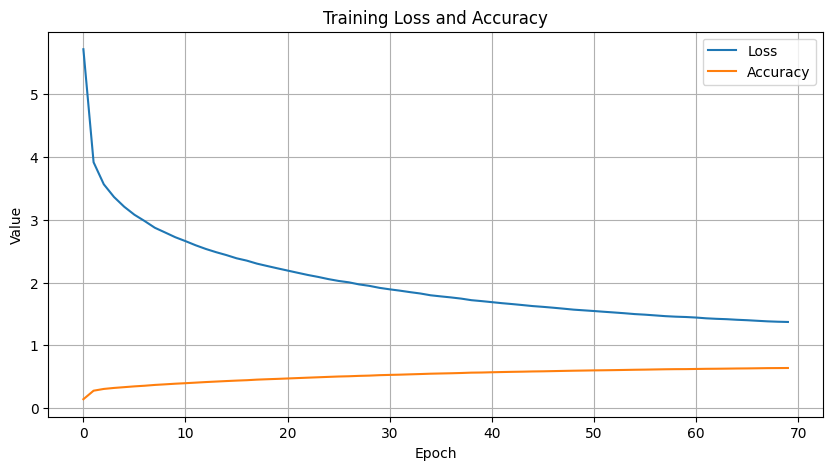

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history_all['loss'], label='Loss')
plt.plot(history_all['accuracy'], label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Loss and Accuracy')
plt.legend()
plt.grid(True)
plt.show()


### Generate captions for images



In [20]:
# Index to word: Use the built-in reverse mapping
def idx_to_word(integer, tokenizer):
    return tokenizer.index_word.get(integer)

# Caption generator function
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq '  # same as preproccess
    for _ in range(max_length):
        # Encode and pad input sequence
        seq = tokenizer.texts_to_sequences([in_text])[0]
        seq = pad_sequences([seq], maxlen=max_length, padding='post')

        # Predict the next word
        yhat = model.predict([image, seq], verbose=0)
        next_index = np.argmax(yhat)
        next_word = idx_to_word(next_index, tokenizer)

        # Stop if word is unknown or end token
        if next_word is None or next_word == 'endseq':
            break

        # Append word to input sequence
        in_text += ' ' + next_word

    return in_text.replace('startseq', '').strip()

### Visualize image - captions - predicted caption

In [21]:
import matplotlib.pyplot as plt
from PIL import Image
import os

BASE_DIR = '/content/drive/MyDrive/flickr30k_images/flickr30k_images/'

def visualize_prediction(image_name):
    image_id = image_name.split('.')[0]
    image_path = os.path.join(BASE_DIR, image_name)
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    print('_______________________Actual_________________')
    for caption in mapping[image_id + '.jpg']:
        print(caption.replace('startseq', '').replace('endseq', '').strip())

    y_pred = predict_caption(model, Img_features[image_id].reshape(1, 4096), tokenizer, max_length_cap)
    print('_____________________Predicted________________')
    print(y_pred)

### Test captioning for a random image

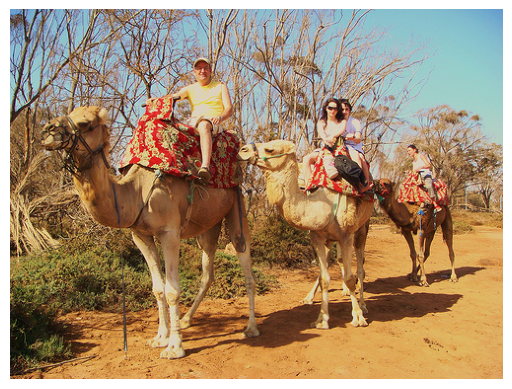

_______________________Actual_________________
group of people riding camels in area with some brush and trees
several people ride on camels as they take leisurely stroll on dirt road
tourist are enjoying the cameos at foreign country
group travels on the back of camels
group of people riding camels
_____________________Predicted________________
man riding bucking horse in the middle of the street


In [42]:
import random

# Pick a random image ID from the test set
IMG = random.choice(test_id)

# Visualize the prediction for that image
visualize_prediction(IMG)

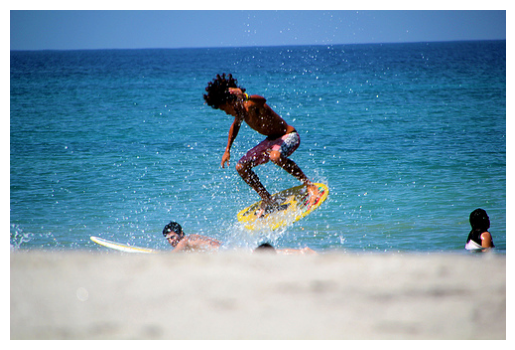

_______________________Actual_________________
surfers in swimming trunks riding waves on their surfboards in the blue ocean
man is doing jump on the surfboard near other people in the water
group of people are surfing in the ocean
surfer gets air while others watch
the image links are broken
_____________________Predicted________________
man is riding his board on beach with his friends


In [44]:
# Pick a random image ID from the test set
IMG = random.choice(test_id)

# Visualize the prediction for that image
visualize_prediction(IMG)

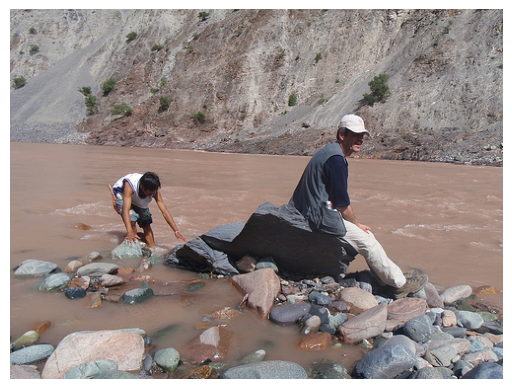

_______________________Actual_________________
man in white khakis white hat black and gray vest and young boy in white and dark colored shorts appear to be fishing or looking for precious gems in muddy water
man in hat rests on big rock in the middle of muddy river as another man behind him carefully makes his way to the rocky path
one man stands in the shallow water while another sits on rock by river with rock cliff in the background
two people are in this picture and one is in the dirty water and the other is sitting on rocks
an older man sits on the rocks and looks on as the younger man investigates what is in the water
_____________________Predicted________________
woman and man sitting in the sand on beach


In [45]:
# Pick a random image ID from the test set
IMG = random.choice(test_id)

# Visualize the prediction for that image
visualize_prediction(IMG)

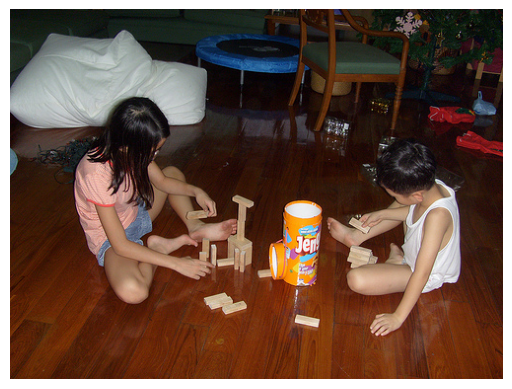

_______________________Actual_________________
boy and girl play with blocks while sitting on wooden floor
young boy and young girl playing jenga on wood floor
girl and boy child playing game of jenga
two children are playing with jenga blocks
two children play jenga on wooden floor
_____________________Predicted________________
little girl is putting on craft in front of some blocks


In [46]:
import random

# Pick a random image ID from the test set
IMG = random.choice(test_id)

# Visualize the prediction for that image
visualize_prediction(IMG)

🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩

### Resume training

In [26]:
start_epoch = 71
end_epoch = 130
batch_size = 64
steps = len(train_id) // batch_size

# Resume training
for epoch in range(start_epoch, end_epoch + 1):
    print(f'  Epoch: {epoch}')
    generator = data_generator(train_id, Img_features, mapping, tokenizer, max_length_cap, vocab_size, batch_size)
    history = model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

    # Append metrics
    history_all['loss'].append(history.history['loss'][0])
    history_all['accuracy'].append(history.history['accuracy'][0])

    # Save model and history together every N epochs
    if epoch % 5 == 0:
        model.save(f'/content/drive/MyDrive/flickr30k_images/model_epoch{epoch}.h5')
        with open('/content/drive/MyDrive/flickr30k_images/history.pkl', 'wb') as f:
            pickle.dump(history_all, f)
        print(f"✅ Saved model and history at epoch {epoch}")


  Epoch: 71
446/446 ━━━━━━━━━━━━━━━━━━━━ 86s 188ms/step - accuracy: 0.6402 - loss: 1.3619
  Epoch: 72
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 185ms/step - accuracy: 0.6404 - loss: 1.3591
  Epoch: 73
446/446 ━━━━━━━━━━━━━━━━━━━━ 81s 182ms/step - accuracy: 0.6426 - loss: 1.3459
  Epoch: 74
446/446 ━━━━━━━━━━━━━━━━━━━━ 81s 182ms/step - accuracy: 0.6439 - loss: 1.3428
  Epoch: 75
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 185ms/step - accuracy: 0.6450 - loss: 1.3368


✅ Saved model and history at epoch 75
  Epoch: 76
446/446 ━━━━━━━━━━━━━━━━━━━━ 81s 181ms/step - accuracy: 0.6467 - loss: 1.3306
  Epoch: 77
446/446 ━━━━━━━━━━━━━━━━━━━━ 80s 180ms/step - accuracy: 0.6480 - loss: 1.3262
  Epoch: 78
446/446 ━━━━━━━━━━━━━━━━━━━━ 82s 183ms/step - accuracy: 0.6499 - loss: 1.3171
  Epoch: 79
446/446 ━━━━━━━━━━━━━━━━━━━━ 80s 180ms/step - accuracy: 0.6511 - loss: 1.3113
  Epoch: 80
446/446 ━━━━━━━━━━━━━━━━━━━━ 80s 180ms/step - accuracy: 0.6524 - loss: 1.3046


✅ Saved model and history at epoch 80
  Epoch: 81
446/446 ━━━━━━━━━━━━━━━━━━━━ 81s 182ms/step - accuracy: 0.6528 - loss: 1.3027
  Epoch: 82
446/446 ━━━━━━━━━━━━━━━━━━━━ 80s 180ms/step - accuracy: 0.6555 - loss: 1.2936
  Epoch: 83
446/446 ━━━━━━━━━━━━━━━━━━━━ 81s 180ms/step - accuracy: 0.6555 - loss: 1.2910
  Epoch: 84
446/446 ━━━━━━━━━━━━━━━━━━━━ 81s 183ms/step - accuracy: 0.6560 - loss: 1.2884
  Epoch: 85
446/446 ━━━━━━━━━━━━━━━━━━━━ 80s 180ms/step - accuracy: 0.6570 - loss: 1.2825


✅ Saved model and history at epoch 85
  Epoch: 86
446/446 ━━━━━━━━━━━━━━━━━━━━ 81s 180ms/step - accuracy: 0.6581 - loss: 1.2786
  Epoch: 87
446/446 ━━━━━━━━━━━━━━━━━━━━ 81s 181ms/step - accuracy: 0.6608 - loss: 1.2692
  Epoch: 88
446/446 ━━━━━━━━━━━━━━━━━━━━ 80s 180ms/step - accuracy: 0.6602 - loss: 1.2684
  Epoch: 89
446/446 ━━━━━━━━━━━━━━━━━━━━ 81s 180ms/step - accuracy: 0.6629 - loss: 1.2583
  Epoch: 90
446/446 ━━━━━━━━━━━━━━━━━━━━ 81s 181ms/step - accuracy: 0.6630 - loss: 1.2565


✅ Saved model and history at epoch 90
  Epoch: 91
446/446 ━━━━━━━━━━━━━━━━━━━━ 81s 181ms/step - accuracy: 0.6642 - loss: 1.2513
  Epoch: 92
446/446 ━━━━━━━━━━━━━━━━━━━━ 80s 180ms/step - accuracy: 0.6647 - loss: 1.2492
  Epoch: 93
446/446 ━━━━━━━━━━━━━━━━━━━━ 81s 182ms/step - accuracy: 0.6651 - loss: 1.2454
  Epoch: 94
446/446 ━━━━━━━━━━━━━━━━━━━━ 80s 180ms/step - accuracy: 0.6666 - loss: 1.2408
  Epoch: 95
446/446 ━━━━━━━━━━━━━━━━━━━━ 80s 180ms/step - accuracy: 0.6679 - loss: 1.2356


✅ Saved model and history at epoch 95
  Epoch: 96
446/446 ━━━━━━━━━━━━━━━━━━━━ 82s 183ms/step - accuracy: 0.6675 - loss: 1.2363
  Epoch: 97
446/446 ━━━━━━━━━━━━━━━━━━━━ 81s 181ms/step - accuracy: 0.6699 - loss: 1.2286
  Epoch: 98
446/446 ━━━━━━━━━━━━━━━━━━━━ 80s 180ms/step - accuracy: 0.6702 - loss: 1.2242
  Epoch: 99
446/446 ━━━━━━━━━━━━━━━━━━━━ 81s 182ms/step - accuracy: 0.6714 - loss: 1.2196
  Epoch: 100
446/446 ━━━━━━━━━━━━━━━━━━━━ 80s 180ms/step - accuracy: 0.6712 - loss: 1.2191


✅ Saved model and history at epoch 100
  Epoch: 101
446/446 ━━━━━━━━━━━━━━━━━━━━ 81s 182ms/step - accuracy: 0.6723 - loss: 1.2148
  Epoch: 102
446/446 ━━━━━━━━━━━━━━━━━━━━ 81s 182ms/step - accuracy: 0.6728 - loss: 1.2117
  Epoch: 103
446/446 ━━━━━━━━━━━━━━━━━━━━ 81s 181ms/step - accuracy: 0.6730 - loss: 1.2098
  Epoch: 104
446/446 ━━━━━━━━━━━━━━━━━━━━ 81s 180ms/step - accuracy: 0.6730 - loss: 1.2071
  Epoch: 105
446/446 ━━━━━━━━━━━━━━━━━━━━ 81s 182ms/step - accuracy: 0.6752 - loss: 1.2000


✅ Saved model and history at epoch 105
  Epoch: 106
446/446 ━━━━━━━━━━━━━━━━━━━━ 81s 182ms/step - accuracy: 0.6755 - loss: 1.1975
  Epoch: 107
446/446 ━━━━━━━━━━━━━━━━━━━━ 81s 181ms/step - accuracy: 0.6771 - loss: 1.1936
  Epoch: 108
446/446 ━━━━━━━━━━━━━━━━━━━━ 81s 182ms/step - accuracy: 0.6789 - loss: 1.1864
  Epoch: 109
446/446 ━━━━━━━━━━━━━━━━━━━━ 81s 182ms/step - accuracy: 0.6778 - loss: 1.1897
  Epoch: 110
446/446 ━━━━━━━━━━━━━━━━━━━━ 81s 182ms/step - accuracy: 0.6788 - loss: 1.1824


✅ Saved model and history at epoch 110
  Epoch: 111
446/446 ━━━━━━━━━━━━━━━━━━━━ 82s 185ms/step - accuracy: 0.6788 - loss: 1.1835
  Epoch: 112
446/446 ━━━━━━━━━━━━━━━━━━━━ 80s 180ms/step - accuracy: 0.6794 - loss: 1.1813
  Epoch: 113
446/446 ━━━━━━━━━━━━━━━━━━━━ 81s 180ms/step - accuracy: 0.6798 - loss: 1.1799
  Epoch: 114
446/446 ━━━━━━━━━━━━━━━━━━━━ 81s 182ms/step - accuracy: 0.6816 - loss: 1.1718
  Epoch: 115
446/446 ━━━━━━━━━━━━━━━━━━━━ 80s 180ms/step - accuracy: 0.6813 - loss: 1.1724


✅ Saved model and history at epoch 115
  Epoch: 116
446/446 ━━━━━━━━━━━━━━━━━━━━ 81s 182ms/step - accuracy: 0.6822 - loss: 1.1687
  Epoch: 117
446/446 ━━━━━━━━━━━━━━━━━━━━ 81s 182ms/step - accuracy: 0.6843 - loss: 1.1612
  Epoch: 118
446/446 ━━━━━━━━━━━━━━━━━━━━ 81s 182ms/step - accuracy: 0.6823 - loss: 1.1653
  Epoch: 119
446/446 ━━━━━━━━━━━━━━━━━━━━ 80s 180ms/step - accuracy: 0.6844 - loss: 1.1600
  Epoch: 120
446/446 ━━━━━━━━━━━━━━━━━━━━ 81s 182ms/step - accuracy: 0.6858 - loss: 1.1541


✅ Saved model and history at epoch 120
  Epoch: 121
446/446 ━━━━━━━━━━━━━━━━━━━━ 82s 183ms/step - accuracy: 0.6862 - loss: 1.1533
  Epoch: 122
446/446 ━━━━━━━━━━━━━━━━━━━━ 81s 181ms/step - accuracy: 0.6866 - loss: 1.1487
  Epoch: 123
446/446 ━━━━━━━━━━━━━━━━━━━━ 82s 183ms/step - accuracy: 0.6863 - loss: 1.1503
  Epoch: 124
446/446 ━━━━━━━━━━━━━━━━━━━━ 81s 181ms/step - accuracy: 0.6872 - loss: 1.1468
  Epoch: 125
446/446 ━━━━━━━━━━━━━━━━━━━━ 81s 182ms/step - accuracy: 0.6885 - loss: 1.1407


✅ Saved model and history at epoch 125
  Epoch: 126
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 185ms/step - accuracy: 0.6880 - loss: 1.1415
  Epoch: 127
446/446 ━━━━━━━━━━━━━━━━━━━━ 81s 182ms/step - accuracy: 0.6903 - loss: 1.1344
  Epoch: 128
446/446 ━━━━━━━━━━━━━━━━━━━━ 82s 184ms/step - accuracy: 0.6866 - loss: 1.1459
  Epoch: 129
446/446 ━━━━━━━━━━━━━━━━━━━━ 87s 194ms/step - accuracy: 0.6891 - loss: 1.1356
  Epoch: 130
446/446 ━━━━━━━━━━━━━━━━━━━━ 83s 184ms/step - accuracy: 0.6902 - loss: 1.1340


✅ Saved model and history at epoch 130


### Save again for the last time

In [27]:
# Save model last
model.save('/content/drive/MyDrive/flickr30k_images/last_Model.keras')

# Save training history
with open('/content/drive/MyDrive/flickr30k_images/last_history.pkl', 'wb') as f:
    pickle.dump(history_all, f)

### Reload the last saved

### ... mount, import, test_id, data_generator, caption, visualize ....

In [26]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/flickr30k_images/last_Model.keras')

history_all = pickle.load(open('/content/drive/MyDrive/flickr30k_images/last_history.pkl', 'rb'))

### Plot full learning curve

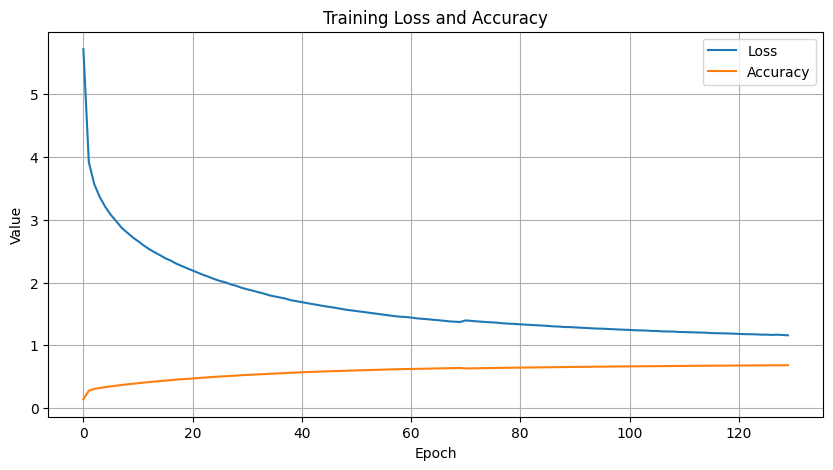

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history_all['loss'], label='Loss')
plt.plot(history_all['accuracy'], label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Loss and Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### Display some images and the predicted captions after full training

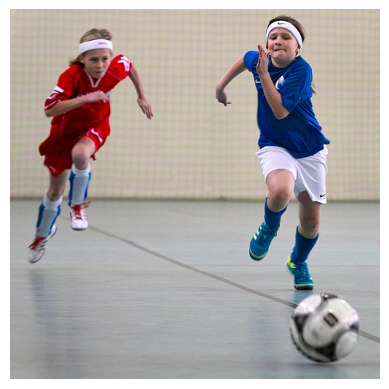

_______________________Actual_________________
two children one wearing blue the other wearing red competing to get ball in game
boy and girl in opposing team uniforms are chasing soccer ball in an inside court
two young boys playing indoor soccer one wears blue and white the other wears red
two young boys playing indoor soccer simultaneously chasing after the soccer ball
young soccer players are running to kick the soccer ball
_____________________Predicted________________
four speed individuals are wearing blue uniform and on basketball field


In [22]:
import random

# Pick a random image ID from the test set
IMG = random.choice(test_id)

# Visualize the prediction for that image
visualize_prediction(IMG)

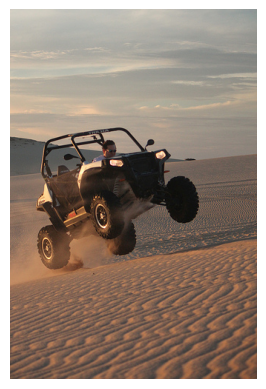

_______________________Actual_________________
out in the desert during golden hour man wearing sunglasses is popping wheelies in dune buggy by himself
man enjoys catching some air while driving his buggy through the sand dunes
dune buggy with one male passenger gets some air as it drives over sand dune
black dune buggy with only the drive pops wheelie in the desert sand
thrill seeker zooms around the desert in his off road vehicle
_____________________Predicted________________
man drives motorcycle


In [23]:
# Pick a random image ID from the test set
IMG = random.choice(test_id)

# Visualize the prediction for that image
visualize_prediction(IMG)

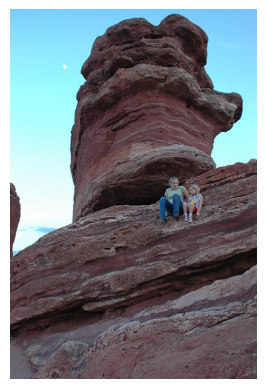

_______________________Actual_________________
young girl and older person are sitting near the top of rock formation
two people sit in the distance on an unusual rock formation
two people are sitting on huge rock formation
woman and little girl sit on desert rock
two girls sit on large rock
_____________________Predicted________________
woman climbing large rocky cliff


In [24]:
# Pick a random image ID from the test set
IMG = random.choice(test_id)

# Visualize the prediction for that image
visualize_prediction(IMG)

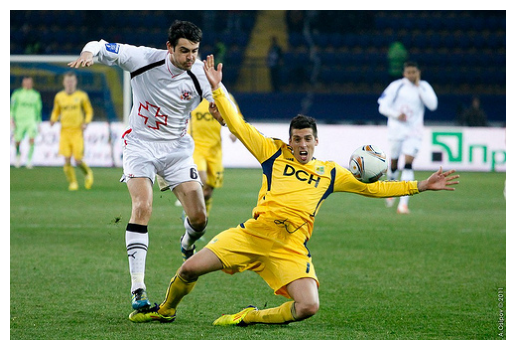

_______________________Actual_________________
man in white uniform is stepping on the foot of man in yellow uniform while the two play soccer on green field with their teammates in the background
while playing soccer man in yellow starts to fall while man in white trips over him stepping on his ankle in the process
two soccer players try to take possession of the ball but the player in yellow falls as the player in white jumps over him
soccer player in white uniform is stepping on soccer player in yellow uniforms foot
soccer player in yellow falls while soccer player in white steps on his foot
_____________________Predicted________________
soccer player in white and black is about to throw ball with teammate


In [25]:
# Pick a random image ID from the test set
IMG = random.choice(test_id)

# Visualize the prediction for that image
visualize_prediction(IMG)

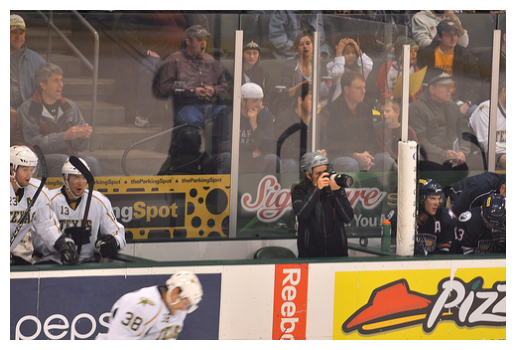

_______________________Actual_________________
several fans are watching hockey game while one takes picture with telephoto lens and two players cheer their team on
spectators sit in the audience at hockey game while photographer takes pictures from box in between the opposing teams
photographer is taking photos of hockey game but he is protecting himself from harm by wearing helmet
photographer at hockey game is taking pictures of the action at the moment
photographer is taking pictures from rinkside of hockey game
_____________________Predicted________________
hockey players called the puck is see baseball audience as he carries two pedestrians


In [30]:
# Pick a random image ID from the test set
IMG = random.choice(test_id)

# Visualize the prediction for that image
visualize_prediction(IMG)

🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓

### **CONCLUSION**:
### The main issue portrayed in this project is that the model does not truly "**pay attention**" to the images. That’s exactly where **modern deep learning** enters the realm of **attention mechanisms** and **transformers**. I believe the whole point of this project is to show why we need transformers and attention:; because with the current setup, even the best achievable accuracy is unable to produce meaningful captions. No matter how much we tweak, without attention, the model simply doesn’t have the capability to see the image the way it should.



🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓
### With this final note, which indicates the need for **further study** and **continuous learning**, I end my internship. Thanks to everyone at CS_Internship whose **generosity** and **integrity** provided me with this great opportunity. Thank you! ❤️
🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓